In [43]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM

In [4]:
df=pd.read_csv('/content/Twitter_Data.csv')
df.head(10)

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
5           kiya tho refresh maarkefir comment karo        0.0
6  surat women perform yagna seeks divine grace f...       0.0
7  this comes from cabinet which has scholars lik...       0.0
8  with upcoming election india saga going import...       1.0
9                         gandhi was gay does modi         1.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98392 entries, 0 to 98391
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   clean_text  98391 non-null  object 
 1   category    98391 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [6]:
df.category.unique()

array([-1.,  0.,  1., nan])

In [7]:
df.describe()

category
count  98391.000000
mean       0.227450
std        0.781591
min       -1.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [8]:
df.isna().sum()

clean_text    1
category      1
dtype: int64

In [9]:
df.columns


Index(['clean_text', 'category'], dtype='object')

In [10]:
df[df['category'].isna()]


clean_text  category
98391  the race lies modi win elections hope i       NaN

In [11]:
df[df['clean_text'].isna()]

clean_text  category
148        NaN       0.0

In [12]:
clean_df=df.drop(df[df['clean_text'].isna()].index, inplace=True)
cat_df=df.drop(df[df['category'].isna()].index, inplace=True)

In [13]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [14]:
def message_text_process(mess):
    no_punctuation = [char for char in mess if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return [word for word in no_punctuation.split() if word.lower()
            not in stopwords.words('english')]

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

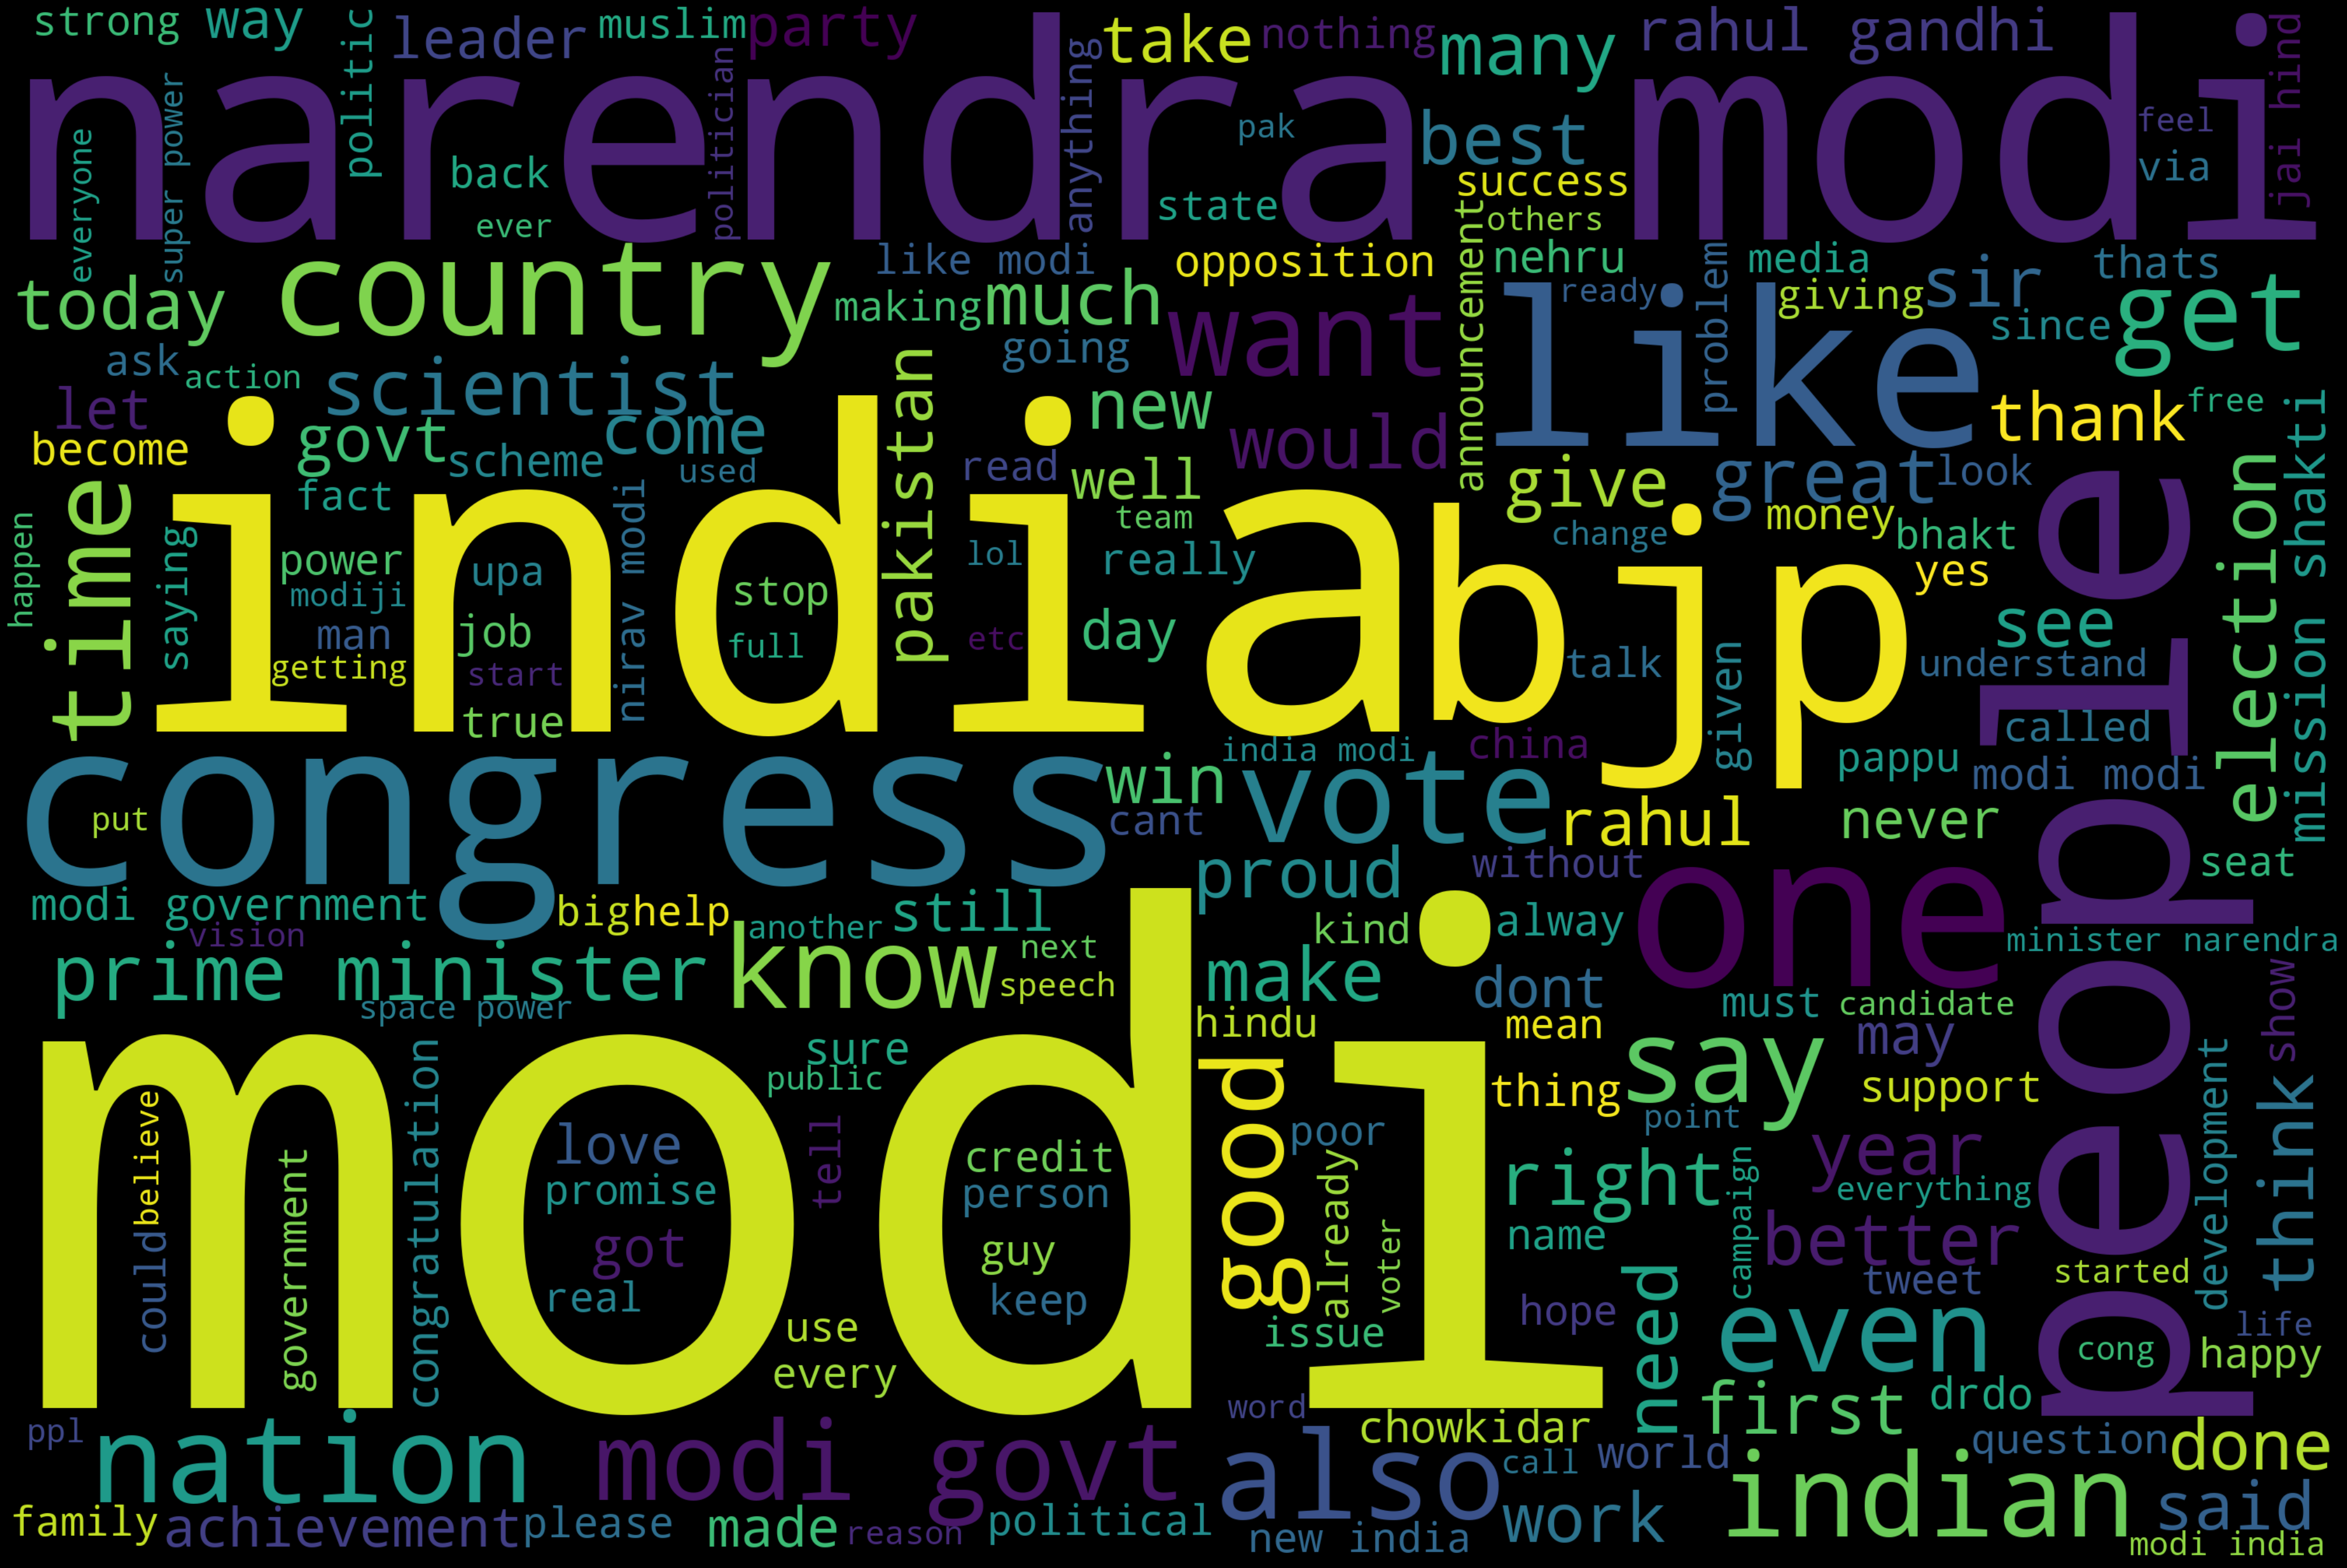

In [17]:
text = ''

for tweet in df[df['category'] == 1.0]['clean_text']:
    text += f" {tweet}"

wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

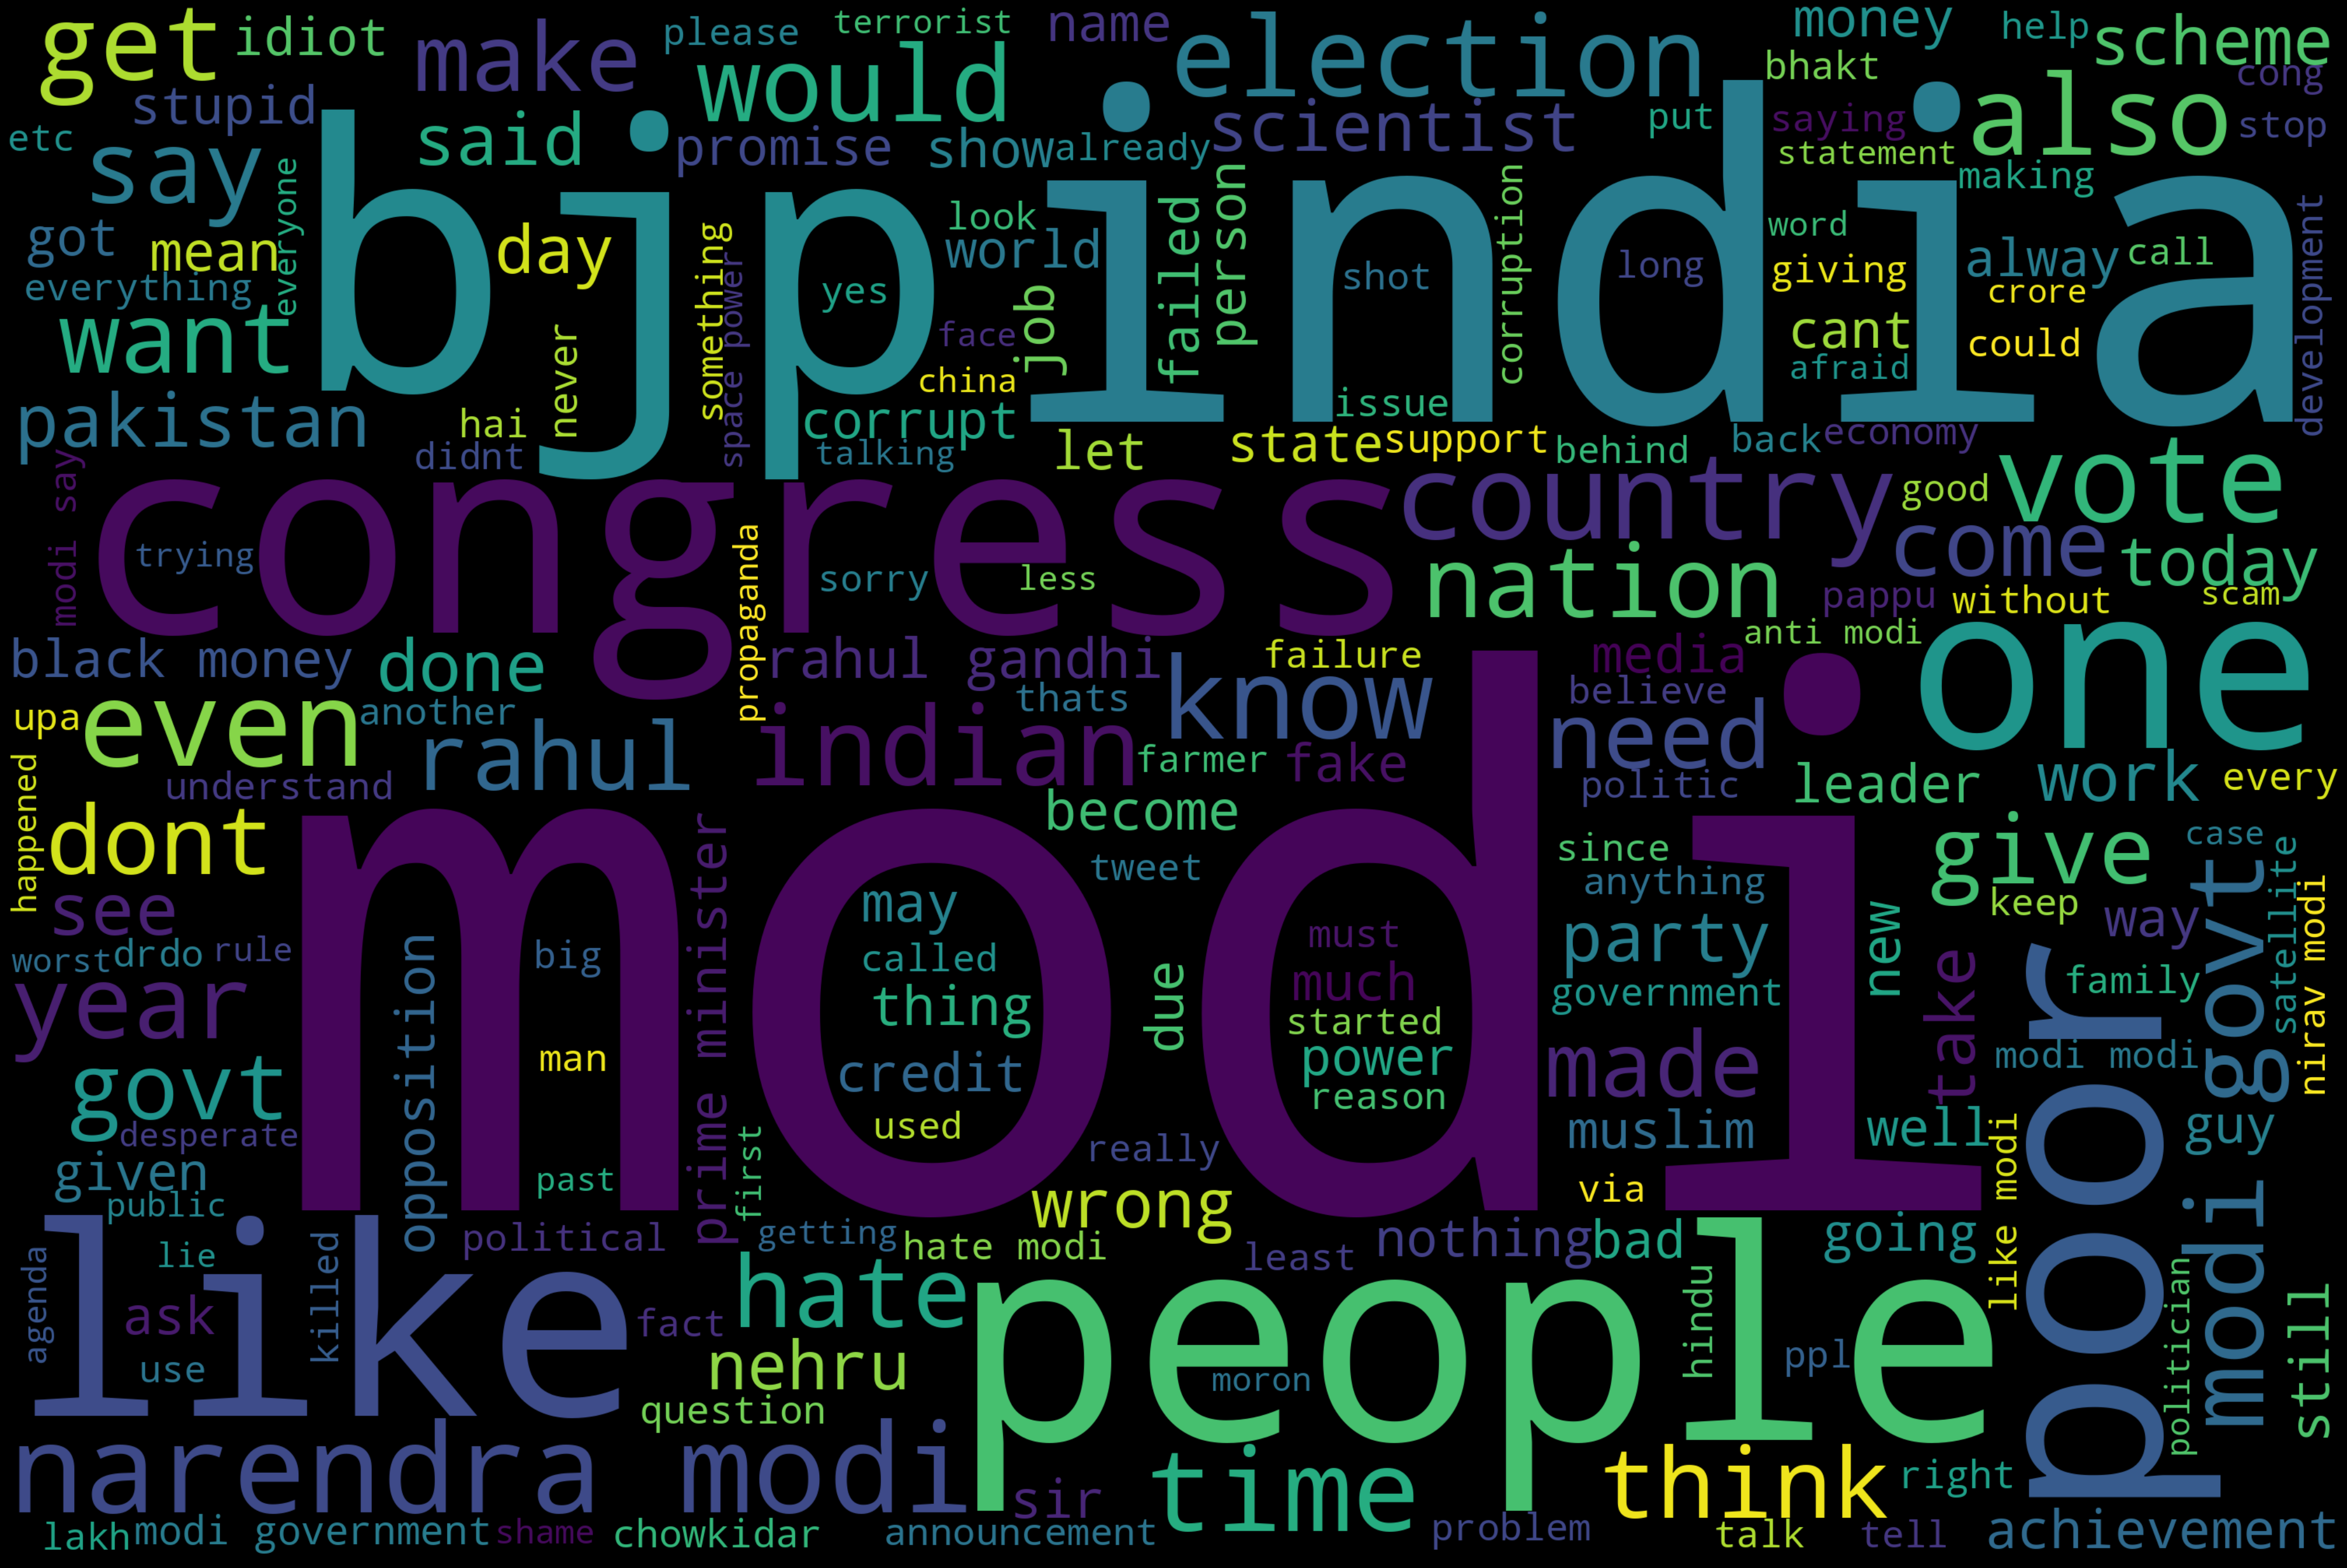

In [18]:
text = ''

for tweet in df[df['category'] == -1.0 ]['clean_text']:
    text += f" {tweet}"

wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

In [19]:
vec = CountVectorizer(max_features=10000)
vec.fit(df['clean_text'])

trn, val = train_test_split(df, test_size=0.3, random_state=42)

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [20]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')

0.9383067384896839

In [21]:
print(clf.score(val_abs, val['category']))


0.9383067384896839


In [22]:
accuracy_score(val['category'], val_preds)


0.9383067384896839

In [23]:
confusion_matrix(val['category'], val_preds)


array([[ 5580,   259,   565],
       [  127,  9603,   176],
       [  461,   233, 12513]])

In [25]:
print(classification_report(val['category'], val_preds))

              precision    recall  f1-score   support

        -1.0       0.90      0.87      0.89      6404
         0.0       0.95      0.97      0.96      9906
         1.0       0.94      0.95      0.95     13207

    accuracy                           0.94     29517
   macro avg       0.93      0.93      0.93     29517
weighted avg       0.94      0.94      0.94     29517



In [26]:
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(df['clean_text']))

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [27]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')

0.9336653453941797

In [28]:
print(clf.score(val_abs, val['category']))

0.9336653453941797


In [29]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [30]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
STOP_WORDS = stopwords.words("english")

In [31]:
# Combining all the above stundents
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        if type(sent) == type(''):
            example1 = BeautifulSoup(sent)
            sent = example1.get_text()
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in STOP_WORDS)
        sent=re.sub("[\d-]",'',sent)#remove digits
        porter=PorterStemmer()
        sent = ' '.join(porter.stem(e) for e in sent.split())
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [32]:
columns=df.columns.values
new_column_names=[]
for i in columns:
    s=i.split()
    d=[]
    for j in s:
        if j==':' or j=='.' or j=='(S)' or j=='(D)':
            pass
        else:
            d.append(j)
    final='_'.join(d)
    new_column_names.append(final)

In [33]:
df.columns=new_column_names

In [34]:
remove_dots=[]
for i in df.columns.values:
  remove_dots.append(i.strip('.'))

In [35]:
df.columns=remove_dots

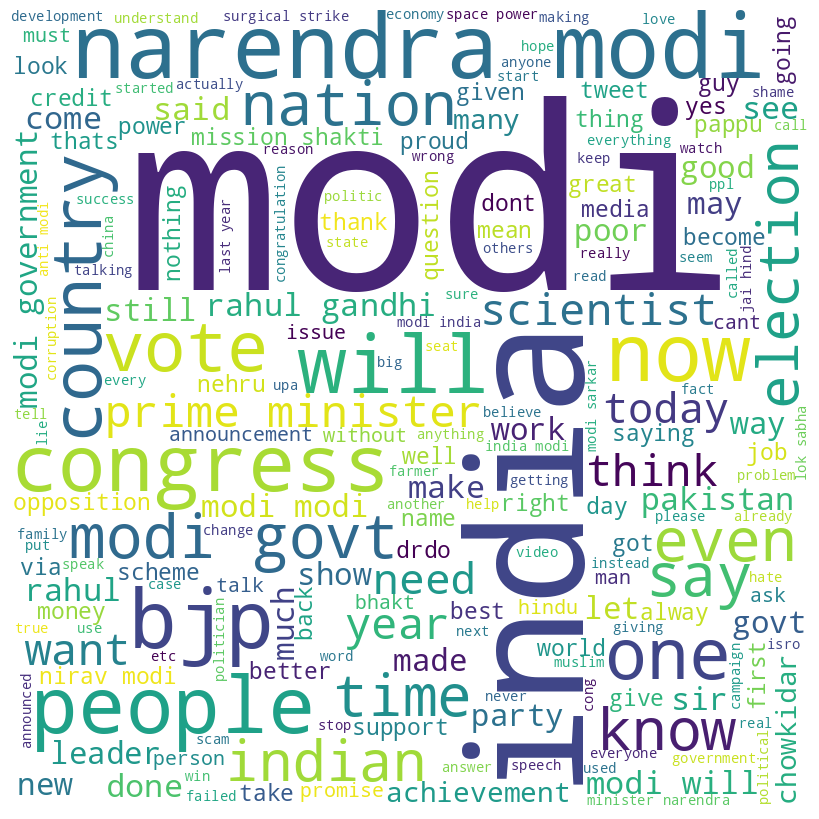

In [36]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the essay column
for val in df['clean_text'].values:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)
  # plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [37]:
# tokenize
tok = Tokenizer(num_words = 1000000)
# fit
tok.fit_on_texts(df['clean_text'].str.lower().tolist())

vocab_size = len(tok.word_index) + 1


In [50]:
X_trn = tok.texts_to_sequences(trn['clean_text'])

In [49]:
maxlen = 200
X_trn = pad_sequences(X_trn, maxlen=maxlen)

In [47]:
embedding_dim = 50
vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

model.add(Flatten())
model.add(Dense(200, activation='relu', name = 'Fully_Connected'))
model.add(Dense(1, activation='sigmoid', name = 'Output'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           4022150   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 Fully_Connected (Dense)     (None, 200)               2000200   
                                                                 
 Output (Dense)              (None, 1)                 201       
                                                                 
Total params: 6,022,551
Trainable params: 6,022,551
Non-trainable params: 0
_________________________________________________________________


<Axes: xlabel='category', ylabel='Density'>

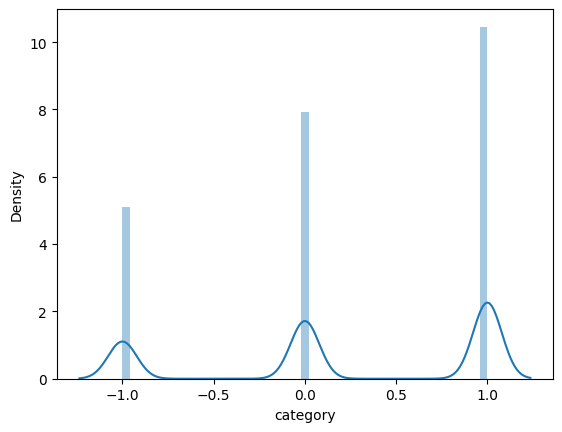

In [53]:
sns.distplot(df['category'])


<Axes: ylabel='count'>

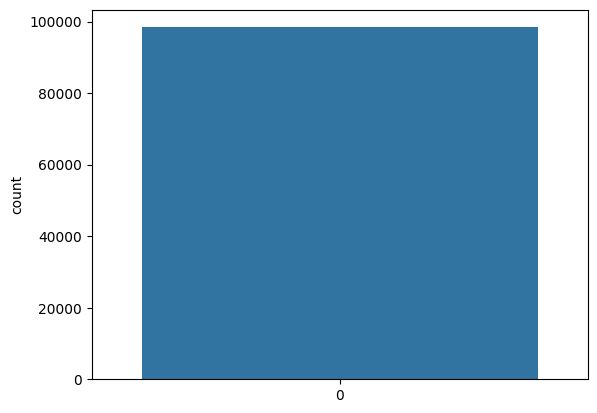

In [54]:
sns.countplot(df["category"])


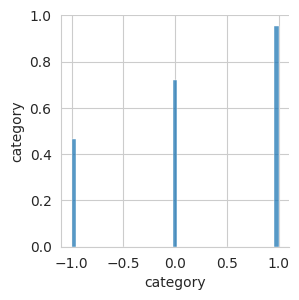

In [55]:
sns.set_style("whitegrid")
sns.pairplot(df[['clean_text','category']], size=3)
plt.show()

<Axes: >

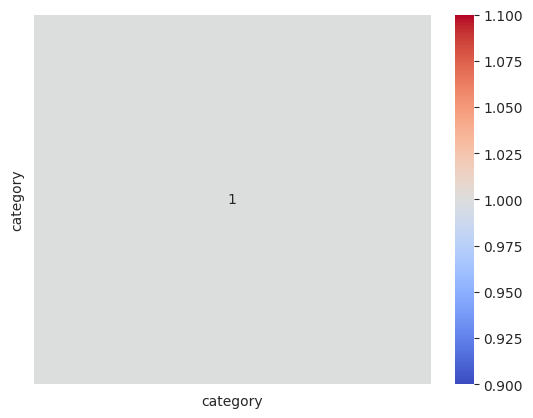

In [56]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')